This notebook performs comprehensive feature engineering on the Amazon product reviews dataset to prepare features for recommendation system models. Based on insights from EDA, we'll create features optimized for both content-based and collaborative filtering approaches.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
import gc
import re
import json

plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

DATA_PATH = Path.cwd().parent / 'data' / 'raw' / 'reviews.csv'
df = pd.read_csv(DATA_PATH).sample(10_000)
print(f"Loaded {df.shape[0]:,} rows, {df.shape[1]} cols | {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

Loaded 10,000 rows, 16 cols | 39.5 MB


## 1. Data Preprocessing and Cleaning

In [2]:
def clean_dataset(df):
    """Clean and preprocess dataset"""
    print("Cleaning dataset...")
    
    df['main_category'] = df['main_category'].fillna('Unknown')
    df['store'] = df['store'].fillna('Unknown Store')
    
    df['price_numeric'] = pd.to_numeric(df['price'], errors='coerce')
    
    category_price_median = df.groupby('main_category')['price_numeric'].median()
    for category in df['main_category'].unique():
        mask = (df['main_category'] == category) & (df['price_numeric'].isna())
        if mask.any() and not pd.isna(category_price_median.get(category)):
            df.loc[mask, 'price_numeric'] = category_price_median[category]
    
    overall_median = df['price_numeric'].median()
    df['price_numeric'] = df['price_numeric'].fillna(overall_median)
    df = df.drop(columns=['price'], errors='ignore')
    
    text_columns = ['title', 'description', 'features']
    for col in text_columns:
        if col in df.columns:
            df[col] = df[col].astype(str)
            df[col] = df[col].str.replace(r'[\[\]\'"]', '', regex=True)
            df[col] = df[col].str.replace(r'\\n', ' ', regex=True)
            df[col] = df[col].replace('nan', '')
    
    df['combined_text'] = (
        df['title'].fillna('') + ' ' + 
        df['description'].fillna('') + ' ' + 
        df['features'].fillna('')
    ).str.strip()
    
    initial_count = len(df)
    df = df[df['combined_text'].str.len() > 10].copy()
    
    df['rating_number'] = df['rating_number'].astype('int32')
    df['average_rating'] = df['average_rating'].astype('float32')
    df['price_numeric'] = df['price_numeric'].astype('float32')
    
    print(f"Cleaned: {df.shape} | Removed {initial_count - len(df):,} rows | {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    return df

df_cleaned = clean_dataset(df)

Cleaning dataset...
Cleaned: (9996, 17) | Removed 4 rows | 54.2 MB
Cleaned: (9996, 17) | Removed 4 rows | 54.2 MB


## 2. Text Feature Engineering for Content-Based Filtering

In [3]:
def create_text_features(df, max_features=5000, min_df=2, max_df=0.95):
    """Create text-based features for content-based recommendation"""
    print("Creating text features...")
    
    df['content_text'] = (
        df['title'].fillna('') + ' ' + 
        df['description'].fillna('') + ' ' + 
        df['features'].fillna('') + ' ' + 
        df['main_category'].fillna('')
    ).str.lower().str.strip()
    
    def preprocess_text(text):
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', str(text))
        text = re.sub(r'\s+', ' ', text)
        return text.strip()
    
    df['content_text_clean'] = df['content_text'].apply(preprocess_text)
    
    tfidf = TfidfVectorizer(
        max_features=max_features,
        min_df=min_df,
        max_df=max_df,
        stop_words='english',
        ngram_range=(1, 2),
        lowercase=True
    )
    
    tfidf_matrix = tfidf.fit_transform(df['content_text_clean'])
    
    category_encoder = LabelEncoder()
    df['category_encoded'] = category_encoder.fit_transform(df['main_category'])
    
    store_encoder = LabelEncoder()
    df['store_encoded'] = store_encoder.fit_transform(df['store'])
    
    feature_names = tfidf.get_feature_names_out()
    tfidf_scores = np.array(tfidf_matrix.mean(axis=0)).flatten()
    
    keyword_importance = pd.DataFrame({
        'keyword': feature_names,
        'importance': tfidf_scores
    }).sort_values('importance', ascending=False)
    
    print(f"TF-IDF: {tfidf_matrix.shape} | Vocab: {len(tfidf.vocabulary_)} | Density: {tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1]):.4f}")
    print(f"Categories: {df['main_category'].nunique()} | Top keywords: {', '.join(keyword_importance.head(5)['keyword'].tolist())}")
    
    return {
        'tfidf_matrix': tfidf_matrix,
        'tfidf_vectorizer': tfidf,
        'category_encoder': category_encoder,
        'store_encoder': store_encoder,
        'keyword_importance': keyword_importance,
        'processed_df': df
    }

text_features = create_text_features(df_cleaned, max_features=3000)
df_with_text = text_features['processed_df']

Creating text features...
TF-IDF: (9996, 3000) | Vocab: 3000 | Density: 0.0204
Categories: 30 | Top keywords: case, camera, usb, cable, power
TF-IDF: (9996, 3000) | Vocab: 3000 | Density: 0.0204
Categories: 30 | Top keywords: case, camera, usb, cable, power


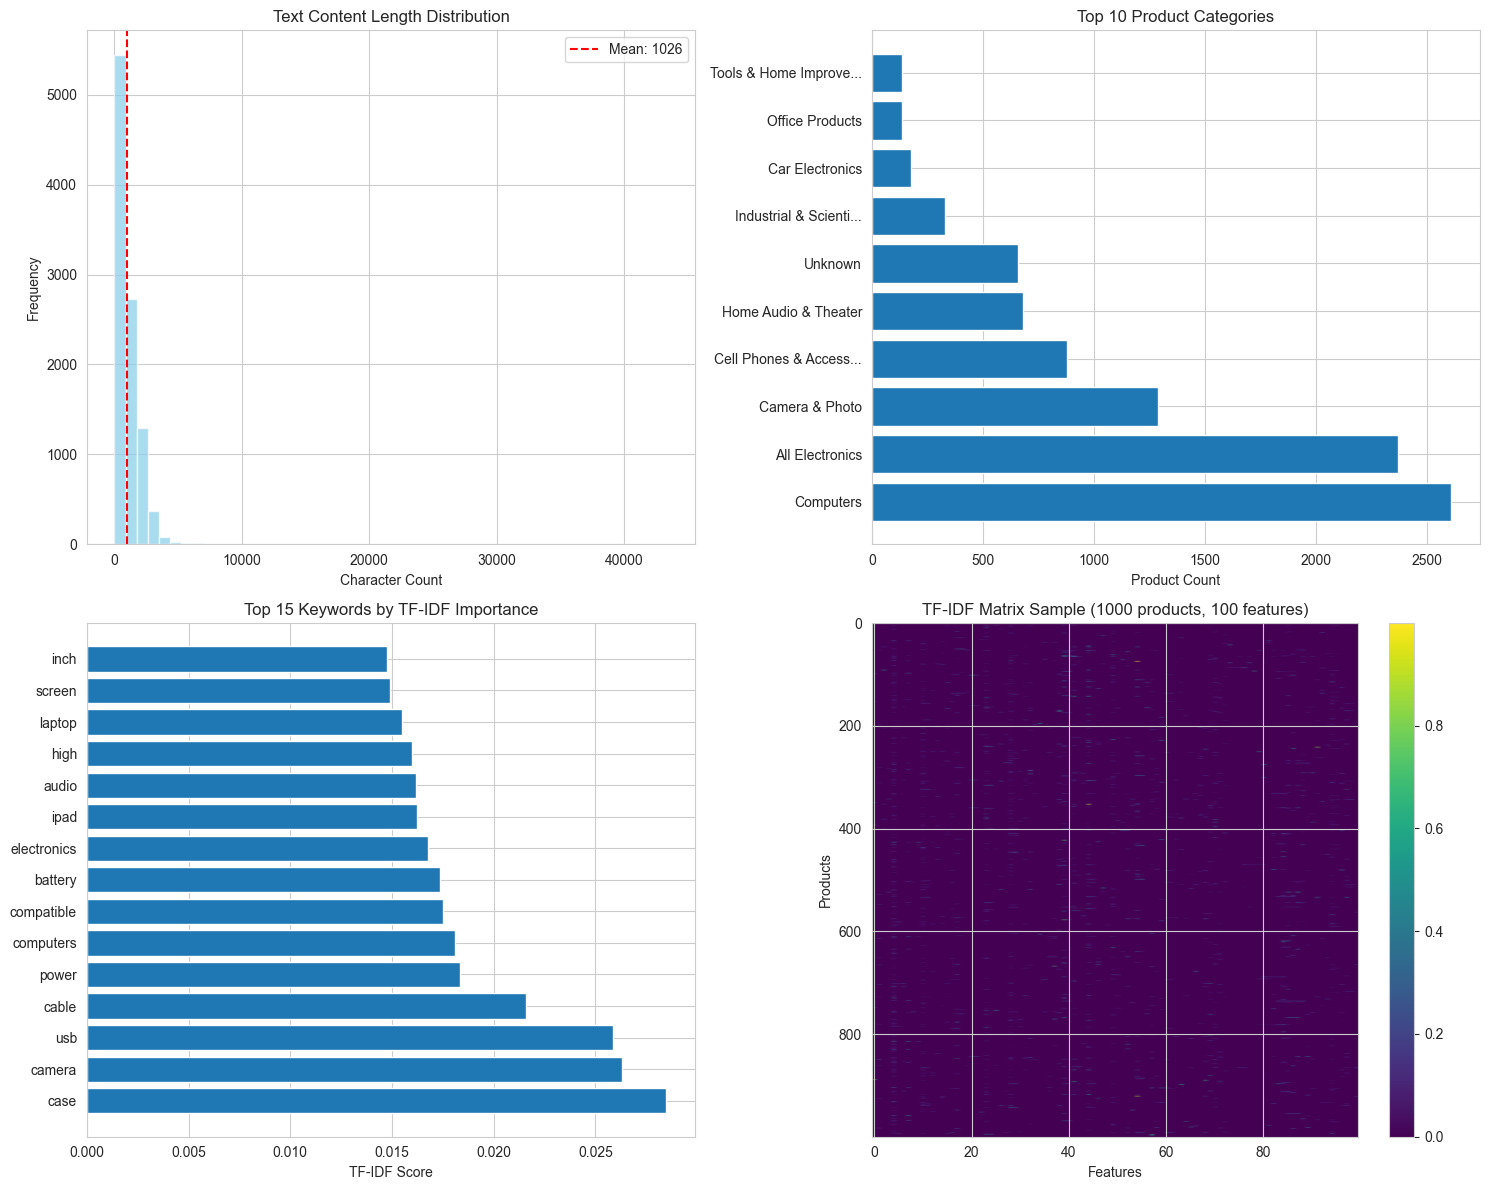

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

text_lengths = df_with_text['content_text_clean'].str.len()
axes[0, 0].hist(text_lengths, bins=50, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Text Content Length Distribution')
axes[0, 0].set_xlabel('Character Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(text_lengths.mean(), color='red', linestyle='--', 
                   label=f'Mean: {text_lengths.mean():.0f}')
axes[0, 0].legend()

top_categories = df_with_text['main_category'].value_counts().head(10)
axes[0, 1].barh(range(len(top_categories)), top_categories.values)
axes[0, 1].set_yticks(range(len(top_categories)))
axes[0, 1].set_yticklabels([cat[:20] + '...' if len(cat) > 20 else cat 
                           for cat in top_categories.index])
axes[0, 1].set_title('Top 10 Product Categories')
axes[0, 1].set_xlabel('Product Count')

top_keywords = text_features['keyword_importance'].head(15)
axes[1, 0].barh(range(len(top_keywords)), top_keywords['importance'])
axes[1, 0].set_yticks(range(len(top_keywords)))
axes[1, 0].set_yticklabels(top_keywords['keyword'])
axes[1, 0].set_title('Top 15 Keywords by TF-IDF Importance')
axes[1, 0].set_xlabel('TF-IDF Score')

tfidf_matrix = text_features['tfidf_matrix']
sample_size = min(1000, tfidf_matrix.shape[0])
sample_indices = np.random.choice(tfidf_matrix.shape[0], sample_size, replace=False)
sample_matrix = tfidf_matrix[sample_indices, :100].toarray()

im = axes[1, 1].imshow(sample_matrix, cmap='viridis', aspect='auto')
axes[1, 1].set_title('TF-IDF Matrix Sample (1000 products, 100 features)')
axes[1, 1].set_xlabel('Features')
axes[1, 1].set_ylabel('Products')
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()

## 3. Rating and Engagement Feature Engineering

In [5]:
def create_rating_engagement_features(df: pd.DataFrame):
    """Create rating and engagement features"""
    print("Creating rating/engagement features...")
    
    df_features = df.copy()
    
    df_features['rating_quality_score'] = (
        df_features['average_rating'] * np.log1p(df_features['rating_number'])
    )
    
    df_features['rating_reliability'] = np.log1p(df_features['rating_number'])
    
    df_features['rating_category'] = pd.cut(
        df_features['average_rating'],
        bins=[0, 2.5, 3.5, 4.0, 4.5, 5.0],
        labels=['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'],
        include_lowest=True
    )
    
    df_features['engagement_level'] = pd.cut(
        df_features['rating_number'],
        bins=[0, 5, 20, 100, 500, float('inf')],
        labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'],
        include_lowest=True
    )
    
    df_features['popularity_percentile'] = (
        df_features['rating_number'].rank(pct=True) * 100
    )
    
    scaler = MinMaxScaler()
    df_features['engagement_score'] = scaler.fit_transform(
        df_features[['rating_number']]
    ).flatten()
    
    category_stats = df_features.groupby('main_category').agg({
        'average_rating': ['mean', 'std'],
        'rating_number': ['mean', 'median']
    }).round(3)
    
    category_stats.columns = ['category_avg_rating', 'category_rating_std', 
                             'category_avg_engagement', 'category_median_engagement']
    
    df_features = df_features.merge(
        category_stats, 
        left_on='main_category', 
        right_index=True, 
        how='left'
    )
    
    df_features['rating_vs_category'] = (
        df_features['average_rating'] - df_features['category_avg_rating']
    )
    
    df_features['engagement_vs_category'] = (
        df_features['rating_number'] - df_features['category_avg_engagement']
    )
    
    store_stats = df_features.groupby('store').agg({
        'average_rating': 'mean',
        'rating_number': 'sum',
        'parent_asin': 'count'
    }).round(3)
    
    store_stats.columns = ['store_avg_rating', 'store_total_ratings', 'store_product_count']
    
    reliable_stores = store_stats[store_stats['store_product_count'] >= 5]
    
    df_features = df_features.merge(
        reliable_stores[['store_avg_rating']], 
        left_on='store', 
        right_index=True, 
        how='left'
    )
    
    df_features['store_avg_rating'] = df_features['store_avg_rating'].fillna(
        df_features['average_rating'].mean()
    )
    
    df_features['recommendation_score'] = (
        0.7 * df_features['average_rating'] + 
        0.3 * (df_features['engagement_score'] * 5)
    )
    
    df_features['quality_confidence'] = (
        df_features['average_rating'] * 
        (1 - np.exp(-df_features['rating_number'] / 50))
    )
    
    print(f"Created rating/engagement features | Categories: {df_features['main_category'].nunique()}")
    return df_features

df_with_ratings = create_rating_engagement_features(df_with_text)

Creating rating/engagement features...
Created rating/engagement features | Categories: 30


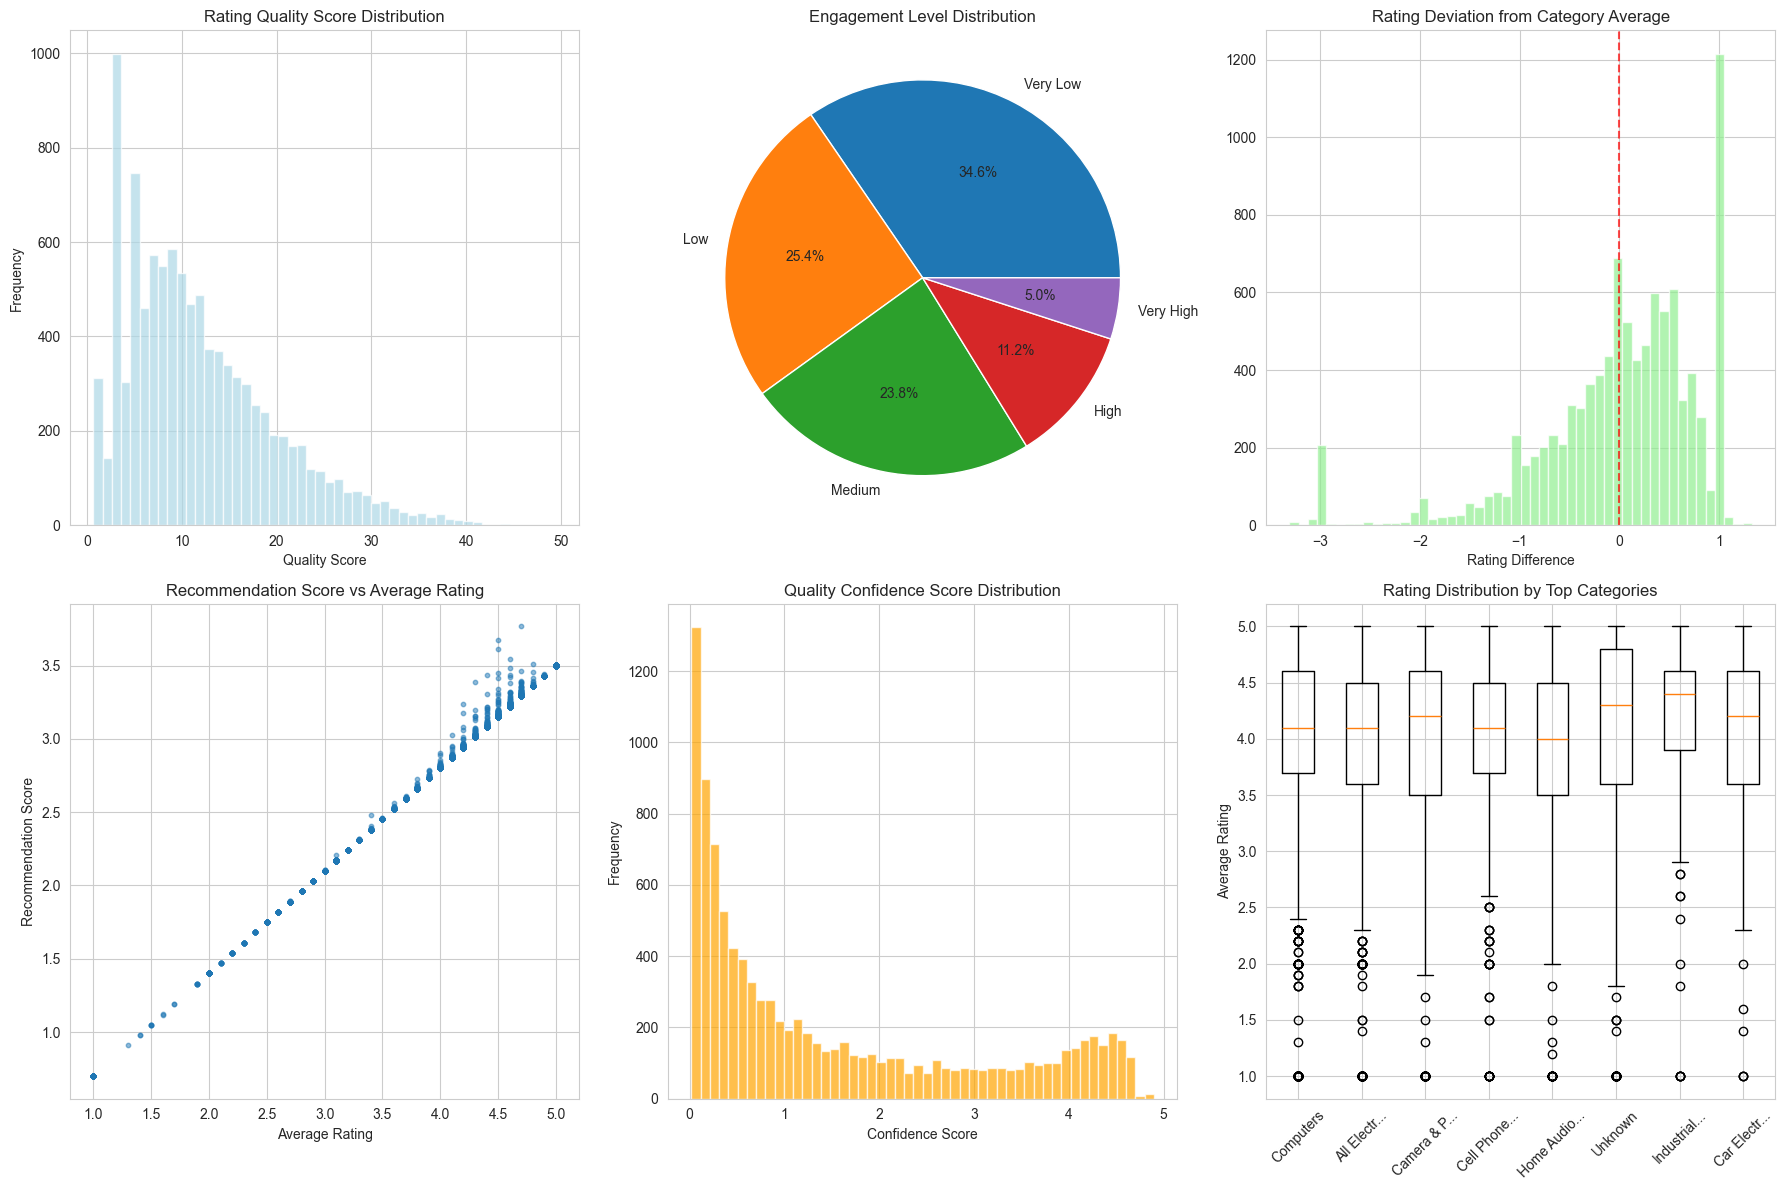

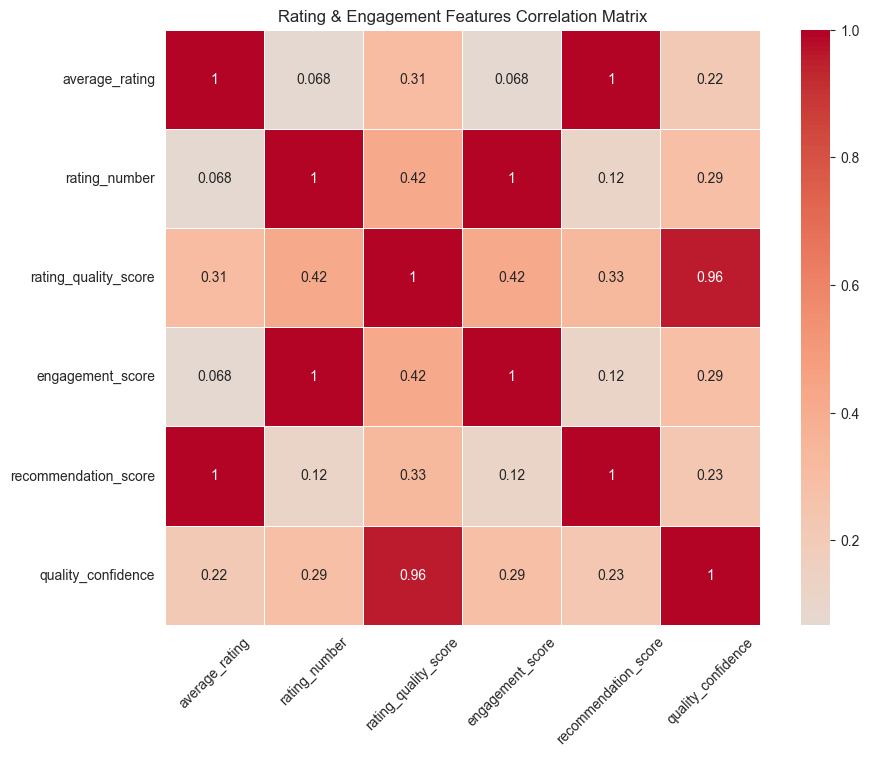

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

axes[0, 0].hist(df_with_ratings['rating_quality_score'], bins=50, alpha=0.7, color='lightblue')
axes[0, 0].set_title('Rating Quality Score Distribution')
axes[0, 0].set_xlabel('Quality Score')
axes[0, 0].set_ylabel('Frequency')

engagement_counts = df_with_ratings['engagement_level'].value_counts()
axes[0, 1].pie(engagement_counts.values, labels=engagement_counts.index, autopct='%1.1f%%')
axes[0, 1].set_title('Engagement Level Distribution')

axes[0, 2].hist(df_with_ratings['rating_vs_category'], bins=50, alpha=0.7, color='lightgreen')
axes[0, 2].set_title('Rating Deviation from Category Average')
axes[0, 2].set_xlabel('Rating Difference')
axes[0, 2].axvline(0, color='red', linestyle='--', alpha=0.7)

sample_size = min(5000, len(df_with_ratings))
sample_df = df_with_ratings.sample(sample_size)

axes[1, 0].scatter(sample_df['average_rating'], sample_df['recommendation_score'], 
                   alpha=0.5, s=10)
axes[1, 0].set_xlabel('Average Rating')
axes[1, 0].set_ylabel('Recommendation Score')
axes[1, 0].set_title('Recommendation Score vs Average Rating')

axes[1, 1].hist(df_with_ratings['quality_confidence'], bins=50, alpha=0.7, color='orange')
axes[1, 1].set_title('Quality Confidence Score Distribution')
axes[1, 1].set_xlabel('Confidence Score')
axes[1, 1].set_ylabel('Frequency')

top_categories = df_with_ratings['main_category'].value_counts().head(8).index
category_data = [df_with_ratings[df_with_ratings['main_category'] == cat]['average_rating'] 
                 for cat in top_categories]

axes[1, 2].boxplot(category_data, labels=[cat[:10] + '...' if len(cat) > 10 else cat 
                                         for cat in top_categories])
axes[1, 2].set_title('Rating Distribution by Top Categories')
axes[1, 2].set_ylabel('Average Rating')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

rating_features = ['average_rating', 'rating_number', 'rating_quality_score', 
                  'engagement_score', 'recommendation_score', 'quality_confidence']

correlation_matrix = df_with_ratings[rating_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Rating & Engagement Features Correlation Matrix')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

## 4. Price and Categorical Feature Engineering

In [7]:
def create_price_categorical_features(df: pd.DataFrame):
    """Create price-based and categorical features"""
    print("Creating price/categorical features...")
    
    df_features = df.copy()
    
    price_quantiles = df_features['price_numeric'].quantile([0.25, 0.5, 0.75, 0.9]).values
    df_features['price_tier'] = pd.cut(
        df_features['price_numeric'],
        bins=[0] + list(price_quantiles) + [float('inf')],
        labels=['Budget', 'Economy', 'Mid-Range', 'Premium', 'Luxury'],
        include_lowest=True
    )
    
    df_features['price_log'] = np.log1p(df_features['price_numeric'])
    df_features['price_per_rating'] = (
        df_features['price_numeric'] / (df_features['average_rating'] + 0.1)
    )
    
    category_price_stats = df_features.groupby('main_category')['price_numeric'].agg([
        'mean', 'median', 'std'
    ]).round(2)
    
    category_price_stats.columns = ['category_price_mean', 'category_price_median', 'category_price_std']
    
    df_features = df_features.merge(
        category_price_stats, 
        left_on='main_category', 
        right_index=True, 
        how='left'
    )
    
    df_features['price_vs_category'] = (
        df_features['price_numeric'] - df_features['category_price_median']
    )
    
    df_features['price_percentile_in_category'] = (
        df_features.groupby('main_category')['price_numeric']
        .rank(pct=True) * 100
    )
    
    category_counts = df_features['main_category'].value_counts()
    df_features['category_popularity_rank'] = df_features['main_category'].map(
        category_counts.rank(ascending=False)
    )
    
    store_stats = df_features.groupby('store').agg({
        'parent_asin': 'count',
        'average_rating': 'mean',
        'rating_number': 'sum'
    })
    
    store_stats.columns = ['store_product_count', 'store_avg_rating', 'store_total_engagement']
    
    df_features = df_features.merge(
        store_stats, 
        left_on='store', 
        right_index=True, 
        how='left'
    )
    
    df_features['store_size_category'] = pd.cut(
        df_features['store_product_count'],
        bins=[0, 1, 5, 20, 100, float('inf')],
        labels=['Single', 'Small', 'Medium', 'Large', 'Enterprise'],
        include_lowest=True
    )
    
    scaler_features = ['price_numeric', 'price_log', 'price_per_rating', 
                      'price_vs_category', 'store_product_count']
    
    scaler = StandardScaler()
    
    for feature in scaler_features:
        if feature in df_features.columns:
            df_features[f'{feature}_scaled'] = scaler.fit_transform(
                df_features[[feature]]
            ).flatten()
    
    scaled_count = len([f for f in df_features.columns if '_scaled' in f])
    print(f"Created price features | Scaled: {scaled_count} features | Stores: {df_features['store'].nunique():,}")
    return df_features

df_with_price_cat = create_price_categorical_features(df_with_ratings)

Creating price/categorical features...
Created price features | Scaled: 5 features | Stores: 6,085


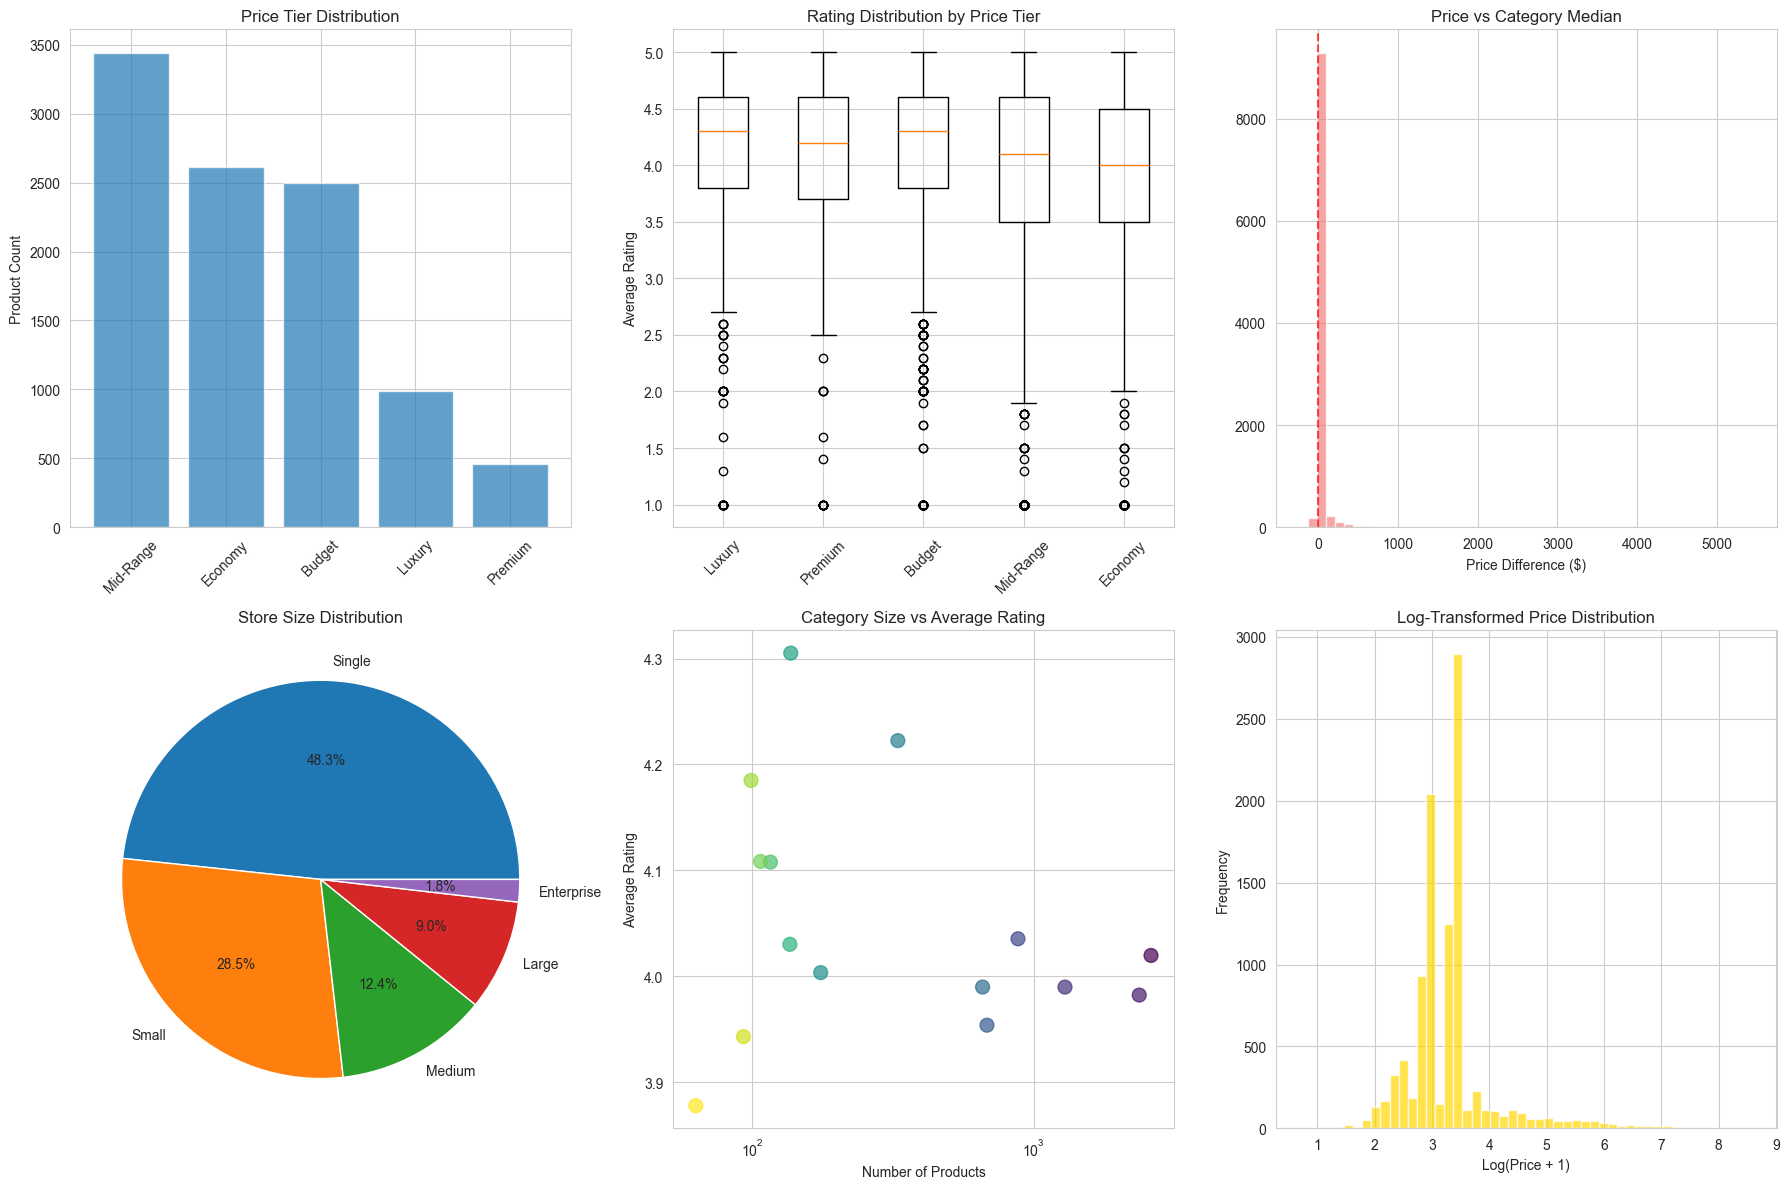

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

price_tier_counts = df_with_price_cat['price_tier'].value_counts()
axes[0, 0].bar(price_tier_counts.index, price_tier_counts.values, alpha=0.7)
axes[0, 0].set_title('Price Tier Distribution')
axes[0, 0].set_ylabel('Product Count')
axes[0, 0].tick_params(axis='x', rotation=45)

price_tiers = df_with_price_cat['price_tier'].unique()
tier_data = [df_with_price_cat[df_with_price_cat['price_tier'] == tier]['average_rating'] 
             for tier in price_tiers if pd.notna(tier)]
tier_labels = [tier for tier in price_tiers if pd.notna(tier)]

axes[0, 1].boxplot(tier_data, labels=tier_labels)
axes[0, 1].set_title('Rating Distribution by Price Tier')
axes[0, 1].set_ylabel('Average Rating')
axes[0, 1].tick_params(axis='x', rotation=45)

axes[0, 2].hist(df_with_price_cat['price_vs_category'], bins=50, alpha=0.7, color='lightcoral')
axes[0, 2].set_title('Price vs Category Median')
axes[0, 2].set_xlabel('Price Difference ($)')
axes[0, 2].axvline(0, color='red', linestyle='--', alpha=0.7)

store_size_counts = df_with_price_cat['store_size_category'].value_counts()
axes[1, 0].pie(store_size_counts.values, labels=store_size_counts.index, autopct='%1.1f%%')
axes[1, 0].set_title('Store Size Distribution')

category_analysis = df_with_price_cat.groupby('main_category').agg({
    'average_rating': 'mean',
    'parent_asin': 'count'
}).reset_index()

top_15_cats = category_analysis.nlargest(15, 'parent_asin')

scatter = axes[1, 1].scatter(top_15_cats['parent_asin'], top_15_cats['average_rating'], 
                            s=100, alpha=0.7, c=range(len(top_15_cats)), cmap='viridis')
axes[1, 1].set_xlabel('Number of Products')
axes[1, 1].set_ylabel('Average Rating')
axes[1, 1].set_title('Category Size vs Average Rating')
axes[1, 1].set_xscale('log')

axes[1, 2].hist(df_with_price_cat['price_log'], bins=50, alpha=0.7, color='gold')
axes[1, 2].set_title('Log-Transformed Price Distribution')
axes[1, 2].set_xlabel('Log(Price + 1)')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 5. Feature Selection and Validation

In [9]:
def prepare_final_features(df: pd.DataFrame, text_features_dict):
    """Prepare final feature set for recommendation models"""
    print("Preparing final features...")
    
    content_features = {
        'tfidf_matrix': text_features_dict['tfidf_matrix'],
        'category_encoded': df['category_encoded'].values,
        'store_encoded': df['store_encoded'].values
    }
    
    collaborative_features = [
        'parent_asin', 'average_rating', 'rating_number', 
        'rating_quality_score', 'engagement_score'
    ]
    
    hybrid_features = [
        'average_rating', 'rating_number', 'price_numeric',
        'rating_quality_score', 'engagement_score', 'recommendation_score',
        'quality_confidence', 'price_tier', 'category_encoded',
        'store_size_category', 'price_vs_category'
    ]
    
    df_numeric = df.copy()
    
    if df_numeric['price_tier'].dtype == 'object' or df_numeric['price_tier'].dtype.name == 'category':
        from sklearn.preprocessing import LabelEncoder
        tier_encoder = LabelEncoder()
        df_numeric['price_tier'] = tier_encoder.fit_transform(df_numeric['price_tier'].astype(str))
    
    if df_numeric['store_size_category'].dtype == 'object' or df_numeric['store_size_category'].dtype.name == 'category':
        size_encoder = LabelEncoder()
        df_numeric['store_size_category'] = size_encoder.fit_transform(df_numeric['store_size_category'].astype(str))
    
    available_hybrid_features = [col for col in hybrid_features if col in df_numeric.columns]
    numerical_features = df_numeric[available_hybrid_features].fillna(0)
    
    scaler = StandardScaler()
    numerical_features_scaled = scaler.fit_transform(numerical_features)
    
    from scipy.sparse import hstack, csr_matrix
    
    category_matrix = csr_matrix(content_features['category_encoded'].reshape(-1, 1))
    store_matrix = csr_matrix(content_features['store_encoded'].reshape(-1, 1))
    
    combined_content_features = hstack([
        content_features['tfidf_matrix'],
        category_matrix,
        store_matrix
    ])
    
    feature_importance = pd.DataFrame({
        'feature': available_hybrid_features,
        'correlation_with_rating': [numerical_features[col].corr(df['average_rating']) 
                                   for col in available_hybrid_features]
    }).sort_values('correlation_with_rating', key=abs, ascending=False)
    
    sample_size = min(50000, len(df))
    sample_indices = np.random.choice(len(df), sample_size, replace=False)
    
    final_datasets = {
        'content_based': {
            'combined_features': combined_content_features[sample_indices],
            'tfidf_matrix': content_features['tfidf_matrix'][sample_indices],
            'category_encoded': content_features['category_encoded'][sample_indices],
            'store_encoded': content_features['store_encoded'][sample_indices],
            'product_ids': df.iloc[sample_indices]['parent_asin'].values,
            'categories': df.iloc[sample_indices]['main_category'].values,
            'ratings': df.iloc[sample_indices]['average_rating'].values
        },
        'collaborative': {
            'user_item_data': df.iloc[sample_indices][['parent_asin', 'average_rating', 'rating_number']],
            'product_features': df.iloc[sample_indices][collaborative_features]
        },
        'hybrid_features': {
            'features': numerical_features_scaled[sample_indices],
            'feature_names': available_hybrid_features,
            'product_ids': df.iloc[sample_indices]['parent_asin'].values,
            'target': df.iloc[sample_indices]['average_rating'].values,
            'combined_with_content': hstack([
                csr_matrix(numerical_features_scaled[sample_indices]),
                combined_content_features[sample_indices]
            ])
        },
        'metadata': {
            'sample_size': sample_size,
            'total_products': len(df),
            'hybrid_feature_count': len(available_hybrid_features),
            'content_feature_count': combined_content_features.shape[1],
            'tfidf_features': content_features['tfidf_matrix'].shape[1],
            'total_combined_features': len(available_hybrid_features) + combined_content_features.shape[1]
        }
    }
    
    print(f"Features: {len(available_hybrid_features)} hybrid + {combined_content_features.shape[1]} content | Sample: {sample_size:,}/{len(df):,}")
    print(f"Top correlations: {', '.join([f'{r.feature}({r.correlation_with_rating:.2f})' for _, r in feature_importance.head(3).iterrows()])}")
    
    return final_datasets, feature_importance

final_features, feature_importance = prepare_final_features(df_with_price_cat, text_features)

Preparing final features...
Features: 11 hybrid + 3002 content | Sample: 9,996/9,996
Top correlations: average_rating(1.00), recommendation_score(1.00), rating_quality_score(0.31)


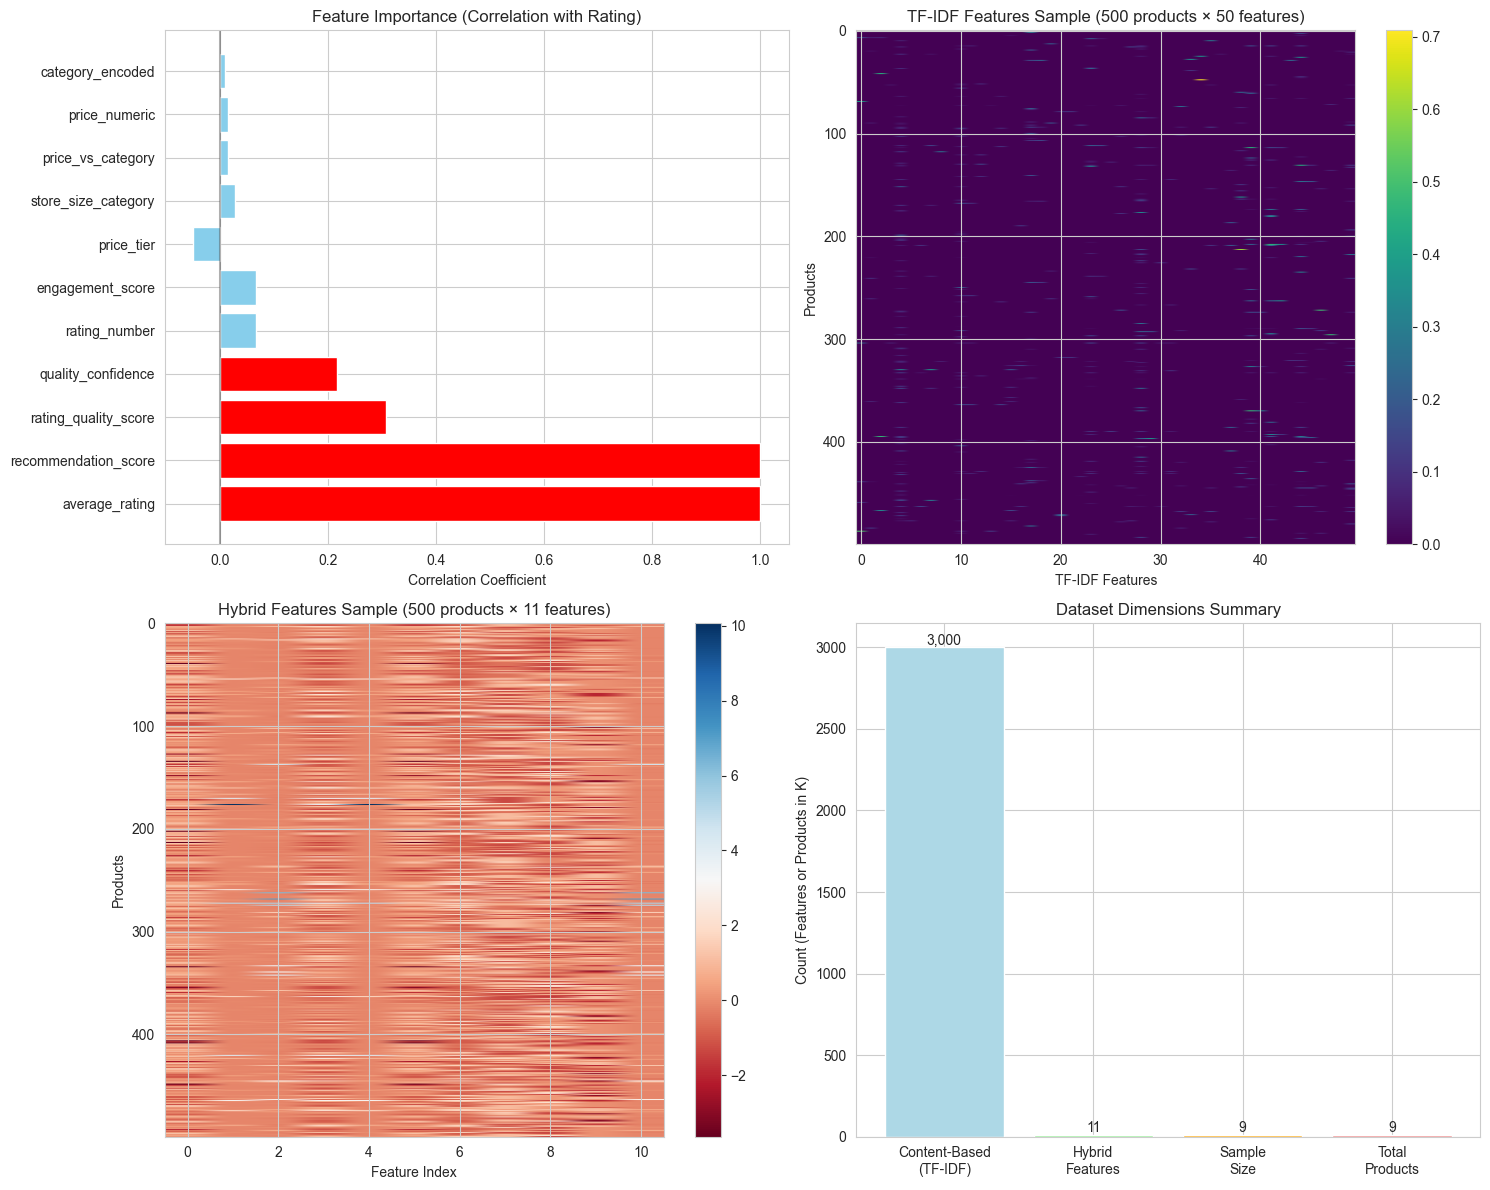

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

top_features = feature_importance.head(12)
colors = ['red' if abs(x) > 0.1 else 'skyblue' for x in top_features['correlation_with_rating']]

axes[0, 0].barh(range(len(top_features)), top_features['correlation_with_rating'], color=colors)
axes[0, 0].set_yticks(range(len(top_features)))
axes[0, 0].set_yticklabels([name[:20] + '...' if len(name) > 20 else name 
                          for name in top_features['feature']])
axes[0, 0].set_title('Feature Importance (Correlation with Rating)')
axes[0, 0].set_xlabel('Correlation Coefficient')
axes[0, 0].axvline(0, color='black', linestyle='-', alpha=0.3)

tfidf_sample = final_features['content_based']['tfidf_matrix'][:500, :50].toarray()
im1 = axes[0, 1].imshow(tfidf_sample, cmap='viridis', aspect='auto')
axes[0, 1].set_title('TF-IDF Features Sample (500 products × 50 features)')
axes[0, 1].set_xlabel('TF-IDF Features')
axes[0, 1].set_ylabel('Products')
plt.colorbar(im1, ax=axes[0, 1])

hybrid_sample = final_features['hybrid_features']['features'][:500, :]
im2 = axes[1, 0].imshow(hybrid_sample, cmap='RdBu', aspect='auto')
axes[1, 0].set_title(f'Hybrid Features Sample (500 products × {hybrid_sample.shape[1]} features)')
axes[1, 0].set_xlabel('Feature Index')
axes[1, 0].set_ylabel('Products')
plt.colorbar(im2, ax=axes[1, 0])

dataset_info = {
    'Content-Based\n(TF-IDF)': final_features['content_based']['tfidf_matrix'].shape[1],
    'Hybrid\nFeatures': len(final_features['hybrid_features']['feature_names']),
    'Sample\nSize': final_features['metadata']['sample_size'] // 1000,
    'Total\nProducts': final_features['metadata']['total_products'] // 1000
}

bars = axes[1, 1].bar(dataset_info.keys(), dataset_info.values(), 
                     color=['lightblue', 'lightgreen', 'orange', 'lightcoral'])
axes[1, 1].set_title('Dataset Dimensions Summary')
axes[1, 1].set_ylabel('Count (Features or Products in K)')

for bar, value in zip(bars, dataset_info.values()):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{value:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 6. Feature Engineering Validation

In [11]:
df_processed = df_with_price_cat
validation_results = {}

hybrid_features = final_features['hybrid_features']['features']
validation_results['missing_values'] = np.isnan(hybrid_features).sum()
validation_results['infinite_values'] = np.isinf(hybrid_features).sum()

content_features = final_features['content_based']['combined_features']
validation_results['content_sparsity'] = 1 - (content_features.nnz / (content_features.shape[0] * content_features.shape[1]))

tfidf_matrix = final_features['content_based']['tfidf_matrix']
validation_results['tfidf_sparsity'] = 1 - (tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1]))

feature_variances = np.var(hybrid_features, axis=0)
validation_results['low_variance_features'] = np.sum(feature_variances < 0.01)

combined_features = final_features['hybrid_features']['combined_with_content']
validation_results['combined_sparsity'] = 1 - (combined_features.nnz / (combined_features.shape[0] * combined_features.shape[1]))

print("Validation Results:")
print(f"  Missing: {validation_results['missing_values']} | Infinite: {validation_results['infinite_values']} | Low variance: {validation_results['low_variance_features']}")
print(f"  Sparsity - Content: {validation_results['content_sparsity']:.4f} | TF-IDF: {validation_results['tfidf_sparsity']:.4f} | Combined: {validation_results['combined_sparsity']:.4f}")
print(f"\nFeature Sets:")
print(f"  Content: {final_features['metadata']['content_feature_count']:,} features (TF-IDF + categorical)")
print(f"  Hybrid: {final_features['metadata']['hybrid_feature_count']} features (rating, price, engagement)")
print(f"  Combined: {final_features['metadata']['total_combined_features']:,} total features")

Validation Results:
  Missing: 0 | Infinite: 0 | Low variance: 0
  Sparsity - Content: 0.9790 | TF-IDF: 0.9796 | Combined: 0.9754

Feature Sets:
  Content: 3,002 features (TF-IDF + categorical)
  Hybrid: 11 features (rating, price, engagement)
  Combined: 3,013 total features


In [12]:
print(f"\nDataset: {len(df_with_price_cat):,} products | Removed: {df.shape[0] - len(df_with_price_cat):,}")
print(f"Features: TF-IDF {final_features['metadata']['tfidf_features']:,} | Categories: {df_with_price_cat['main_category'].nunique()} | Stores: {df_with_price_cat['store'].nunique():,}")
print(f"Stats: Avg rating {df_with_price_cat['average_rating'].mean():.2f}/5.0 | Price ${df_with_price_cat['price_numeric'].min():.0f}-${df_with_price_cat['price_numeric'].max():.0f} | High engagement (>100): {(df_with_price_cat['rating_number'] > 100).sum():,}")
print(f"\nFeature engineering complete.")


Dataset: 9,996 products | Removed: 4
Features: TF-IDF 3,000 | Categories: 30 | Stores: 6,085
Stats: Avg rating 4.01/5.0 | Price $1-$5495 | High engagement (>100): 1,619

Feature engineering complete.
